<a href="https://colab.research.google.com/github/raghadidwaidar/Specil-Topics-Project/blob/main/rgd0226745.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Important Library's

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, optimizers
import os
from tensorflow.keras import layers, models

Load the data & count (ham & spam)

In [ ]:
df = pd.read_csv('spam.csv', encoding='latin-1')
class_counts = df['v1'].value_counts()
print(df['v1'].value_counts())
print(f"Approximate percentage of spam messages: {class_counts['spam'] / class_counts.sum():.2%}")


v1
ham     4825
spam     747
Name: count, dtype: int64
Approximate percentage of spam messages: 13.41%


Calculate Imbalance Ratio

In [ ]:
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

majority_count = class_counts.max()
minority_count = class_counts.min()

imbalance_ratio = majority_count / minority_count

print(f"Imbalance Ratio (Majority / Minority): {imbalance_ratio:.2f} : 1")


Imbalance Ratio (Majority / Minority): 6.46 : 1


Bar chart

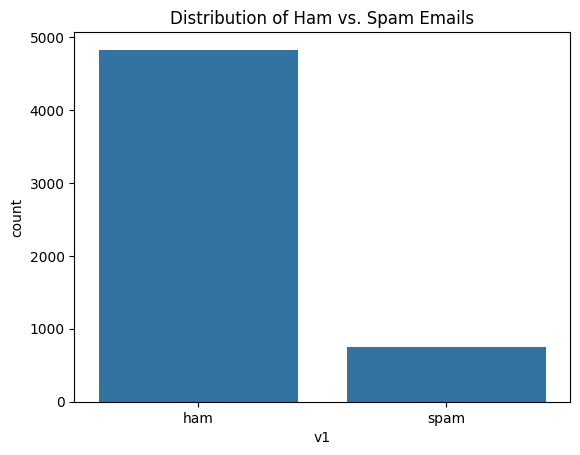

In [ ]:
sns.countplot(x='v1', data=df)
plt.title('Distribution of Ham vs. Spam Emails')
plt.show()

# Data Preprocessing

Separate the minority class (spam)

In [ ]:
spam_df = df[df['v1'] == 'spam']
spam_texts = spam_df['v2'].tolist()

print(f"Number of spam samples for GAN training: {len(spam_texts)}")

Number of spam samples for GAN training: 747


In [ ]:
# Text Preprocessing Functions
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
cleaned_spam_texts = [clean_text(text) for text in spam_texts]

# Tokenization and Vocabulary Building using keras
tokenizer = Tokenizer(num_words=None, oov_token="<unk>")
tokenizer.fit_on_texts(cleaned_spam_texts)
word_index = tokenizer.word_index

# Create reversed dictionary for numerical to text conversion (for generating samples)
index_word = {v: k for k, v in word_index.items()}
index_word[0] = "<pad>"
print(f"\nVocabulary size: {len(word_index)}")

# Convert texts to sequences of integers
spam_sequences = tokenizer.texts_to_sequences(cleaned_spam_texts)

# Determine Max Sequence Length (Important for GAN input)
lengths = [len(s) for s in spam_sequences]
max_sequence_length = int(np.percentile(lengths, 90))
if max_sequence_length == 0:
    max_sequence_length = 20
print(f"Selected max_sequence_length (90th percentile): {max_sequence_length}")

# Pad sequences to a fixed length
padded_spam_sequences = pad_sequences(spam_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
print(f"Shape of padded spam sequences: {padded_spam_sequences.shape}")
print(f"Example original spam text: {spam_texts[0]}")
print(f"Example cleaned spam text: {cleaned_spam_texts[0]}")
print(f"Example padded spam sequence (first 10 tokens): {padded_spam_sequences[0][:10]}")

#embedded
EMBEDDING_DIM = 128
VOCAB_SIZE = len(word_index) + 1
print(f"Embedding dimension chosen: {EMBEDDING_DIM}")
print(f"Vocabulary size for embedding layer: {VOCAB_SIZE}")

#batch size
BUFFER_SIZE = len(padded_spam_sequences)
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices(padded_spam_sequences).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(f"Prepared {len(padded_spam_sequences)} spam sequences for GAN training.")
print(f"Batch size: {BATCH_SIZE}")




Vocabulary size: 2193
Selected max_sequence_length (90th percentile): 27
Shape of padded spam sequences: (747, 27)
Example original spam text: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Example cleaned spam text: free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetcs apply overs
Example padded spam sequence (first 10 tokens): [  7  99  35   3 206 271   2  43 547 469]
Embedding dimension chosen: 128
Vocabulary size for embedding layer: 2194
Prepared 747 spam sequences for GAN training.
Batch size: 64


In [ ]:
#embeddd layer
print(f"Embedding dimension chosen: {EMBEDDING_DIM}")
print(f"Vocabulary size for embedding layer: {VOCAB_SIZE}")

# Create the embedding layer
embedding_layer = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    embeddings_initializer='uniform',
    input_length=max_sequence_length
)

Embedding dimension chosen: 128
Vocabulary size for embedding layer: 2194


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
NOISE_DIM = 100 # Dimension of the random noise vector fed to the Generator

#  Shared Embedding Layer
shared_embedding_layer = tf.keras.layers.Embedding(
    VOCAB_SIZE,
    EMBEDDING_DIM,
    input_length=max_sequence_length,
    trainable=True,
    name='shared_embedding_layer'
)
print("\nShared Embedding Layer created:")
print(f"  Input Dimension (Vocabulary Size): {VOCAB_SIZE}")
print(f"  Output Dimension (Embedding Dimension): {EMBEDDING_DIM}")
print(f"  Input Length (Max Sequence Length): {max_sequence_length}")
print(f"  Trainable: {shared_embedding_layer.trainable}")


Shared Embedding Layer created:
  Input Dimension (Vocabulary Size): 2194
  Output Dimension (Embedding Dimension): 128
  Input Length (Max Sequence Length): 27
  Trainable: True


In [ ]:
#  Generator Model (for both Vanilla GAN and WGAN-GP)
def build_generator_continuous_output(vocab_size, embedding_dim, max_sequence_length, noise_dim):
    """
    Builds the Generator model.
    Takes a noise vector and outputs a sequence of continuous embeddings.
    """
    noise_input = tf.keras.layers.Input(shape=(noise_dim,), name='noise_input')

    # 1. Project noise: Expand the noise vector to a higher dimension.
    x = tf.keras.layers.Dense(max_sequence_length * embedding_dim)(noise_input)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    # 2. Reshape: Transform the flat vector into a 3D tensor suitable for recurrent layers.
    x = tf.keras.layers.Reshape((max_sequence_length, embedding_dim))(x)

    # 3. Recurrent Layers (LSTMs): Process the sequence.
    x = tf.keras.layers.LSTM(embedding_dim, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.LSTM(embedding_dim, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # 4. Output Layer: Produce the final sequence of embeddings.
    output_embeddings = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(embedding_dim, activation='linear'))(x)

    # Create the Keras Model
    model = tf.keras.models.Model(noise_input, output_embeddings, name='generator')
    return model

In [ ]:
#  Discriminator Model (for Vanilla GAN)
def build_discriminator_continuous_input(embedding_dim, max_sequence_length):
    """
    Builds the Discriminator model for Vanilla GAN.
    Takes a sequence of continuous embeddings and outputs a probability (real/fake).
    """
    # 1. Input Layer: Expects a 3D tensor of embedded sequences.
    seq_input = tf.keras.layers.Input(shape=(max_sequence_length, embedding_dim), name='embedded_sequence_input')

    # 2. Recurrent Layer (LSTM): Process the sequence.
    x = tf.keras.layers.LSTM(embedding_dim)(seq_input)
    x = tf.keras.layers.Dropout(0.3)(x)

    # 3. Output Layer: Single neuron with sigmoid activation for binary classification.
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Create the Keras Model
    model = tf.keras.models.Model(seq_input, output, name='discriminator')
    return model

In [ ]:
# Critic Model (for WGAN-GP)
def build_critic_continuous_input(embedding_dim, max_sequence_length):
    """
    Builds the Critic model for WGAN-GP.
    Takes a sequence of continuous embeddings and outputs a real value (no sigmoid).
    """
    # 1. Input Layer: Same as Discriminator, expects embedded sequences.
    seq_input = tf.keras.layers.Input(shape=(max_sequence_length, embedding_dim), name='embedded_sequence_input')

    # 2. Recurrent Layer (LSTM): Process the sequence.
    x = tf.keras.layers.LSTM(embedding_dim)(seq_input)
    x = tf.keras.layers.Dropout(0.3)(x)

    # 3. Output Layer: Single neuron with *no activation* (linear output).
    output = tf.keras.layers.Dense(1)(x)

    # Create the Keras Model
    model = tf.keras.models.Model(seq_input, output, name='critic')
    return model

In [ ]:
# Instantiate Models

# For Vanilla GAN
generator_vanilla = build_generator_continuous_output(VOCAB_SIZE, EMBEDDING_DIM, max_sequence_length, NOISE_DIM)
discriminator_vanilla = build_discriminator_continuous_input(EMBEDDING_DIM, max_sequence_length)

# For WGAN-GP
generator_wgan = build_generator_continuous_output(VOCAB_SIZE, EMBEDDING_DIM, max_sequence_length, NOISE_DIM)
critic_wgan = build_critic_continuous_input(EMBEDDING_DIM, max_sequence_length)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
print("\nVanilla GAN Generator Summary:")
generator_vanilla.summary()


Vanilla GAN Generator Summary:


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ noise_input (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3456)           │       349,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 3456)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 27, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 27, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 27, 128)        │        16,512 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 628,736 (2.40 MB)

 Trainable params: 628,736 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\nVanilla GAN Discriminator Summary:")
discriminator_vanilla.summary()


Vanilla GAN Discriminator Summary:


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedded_sequence_input         │ (None, 27, 128)        │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,713 (514.50 KB)

 Trainable params: 131,713 (514.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\nWGAN-GP Generator Summary:")
generator_wgan.summary()


WGAN-GP Generator Summary:


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ noise_input (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3456)           │       349,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 3456)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 27, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 27, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 27, 128)        │        16,512 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 628,736 (2.40 MB)

 Trainable params: 628,736 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\nWGAN-GP Critic Summary:")
critic_wgan.summary()


WGAN-GP Critic Summary:


Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedded_sequence_input         │ (None, 27, 128)        │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,713 (514.50 KB)

 Trainable params: 131,713 (514.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Optimizers
discriminator_optimizer_vanilla = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
generator_optimizer_vanilla = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
critic_optimizer_wgan = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
generator_optimizer_wgan = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
print("Optimizers defined for both GAN variants.")

Optimizers defined for both GAN variants.


In [ ]:

# Loss for Vanilla GAN: Binary Cross-Entropy
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss_vanilla(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss_vanilla(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
print("Loss functions for Vanilla GAN defined.")

Loss functions for Vanilla GAN defined.


In [ ]:
# Loss for WGAN-GP: Wasserstein Loss + Gradient Penalty
LAMBDA = 10

def discriminator_loss_wgan(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

def generator_loss_wgan(fake_output):
    return -tf.reduce_mean(fake_output)

def gradient_penalty(critic_model, real_sequences_batch, fake_embeddings_batch, shared_embedding_layer):
    """
    Calculates the gradient penalty for WGAN-GP.
    This term enforces the 1-Lipschitz constraint on the Critic.
    """
    # Get the actual batch size for this batch
    current_batch_size = tf.shape(real_sequences_batch)[0]

    # Generate alpha with the correct batch size
    alpha = tf.random.uniform([current_batch_size, 1, 1], 0., 1.)

    real_embeddings_batch = shared_embedding_layer(real_sequences_batch)


    fake_embeddings_batch_sliced = fake_embeddings_batch[:current_batch_size]


    interpolated_embeddings = (alpha * real_embeddings_batch) + ((1 - alpha) * fake_embeddings_batch_sliced)

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated_embeddings)
        interpolated_output = critic_model(interpolated_embeddings, training=True)

    gp_gradients = gp_tape.gradient(interpolated_output, interpolated_embeddings)
    gp_gradients_norm = tf.norm(gp_gradients, axis=[1, 2])
    gp = tf.reduce_mean((gp_gradients_norm - 1)**2)
    return gp
print("Loss functions and Gradient Penalty for WGAN-GP defined.")

Loss functions and Gradient Penalty for WGAN-GP defined.


In [ ]:
# --- Helper Function to Generate and Save Samples ---
def generate_and_save_samples(model, epoch, noise_dim, max_seq_length, index_word_map, gan_type, vocab_size, shared_embedding_layer):
    """
    Generates sample text from the GAN and prints/saves them.
    Assumes the generator outputs continuous embeddings.
    A temporary projection layer is used to convert embeddings to vocabulary logits for sampling.
    """
    # Generate 5 samples for visualization
    noise = tf.random.normal([5, noise_dim])
    generated_embeddings = model(noise, training=False)

    # Create a temporary projection layer to convert embeddings back to vocabulary logits
    temp_projection_layer = layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))

    # Build a dummy model to apply this layer. The input shape should match
    dummy_input = layers.Input(shape=(max_seq_length, generated_embeddings.shape[-1]))
    dummy_output = temp_projection_layer(dummy_input)
    temp_projector_model = models.Model(dummy_input, dummy_output)

    # Get probabilities over vocab for each time step
    vocab_probabilities = temp_projector_model(generated_embeddings)
    # Get the most probable word ID for each time step
    generated_sequences = tf.argmax(vocab_probabilities, axis=-1).numpy()

    print(f"\n--- {gan_type} Generated Samples (Epoch {epoch}) ---")
    for i in range(5):
        # Convert sequence of IDs back to text, filtering out padding
        # Use index_word_map directly, it should handle 0 as <pad>
        sample_text = ' '.join([index_word_map.get(idx, '<unk>') for idx in generated_sequences[i] if idx != 0])
        print(f"Sample {i+1}: {sample_text}")
    print("-------------------------------------------\n")

In [ ]:
# --- Custom Training Step for Vanilla GAN ---
@tf.function
def train_step_vanilla_gan(real_data_batch_sequences):
    # Convert real data integer sequences to embeddings using the shared layer
    real_embeddings_batch = shared_embedding_layer(real_data_batch_sequences)

    # --- Train Discriminator ---
    # Get the actual batch size for this batch
    current_batch_size = tf.shape(real_data_batch_sequences)[0]
    noise = tf.random.normal([current_batch_size, NOISE_DIM]) # Generate noise with actual batch size

    with tf.GradientTape() as d_tape:
        # Generate fake embeddings using the generator
        fake_embeddings = generator_vanilla(noise, training=True)

        # Get discriminator's output for real and fake embeddings
        real_output = discriminator_vanilla(real_embeddings_batch, training=True)
        fake_output = discriminator_vanilla(fake_embeddings, training=True)

        # Calculate discriminator loss
        d_loss = discriminator_loss_vanilla(real_output, fake_output)

    # Compute and apply gradients for the discriminator
    d_gradients = d_tape.gradient(d_loss, discriminator_vanilla.trainable_variables)
    discriminator_optimizer_vanilla.apply_gradients(zip(d_gradients, discriminator_vanilla.trainable_variables))

    # --- Train Generator ---
    # Generate noise again for the generator step with the actual batch size
    noise = tf.random.normal([current_batch_size, NOISE_DIM])
    with tf.GradientTape() as g_tape:
        # Generate fake embeddings
        fake_embeddings = generator_vanilla(noise, training=True)
        # Get discriminator's output for fake embeddings (from generator's perspective)
        fake_output = discriminator_vanilla(fake_embeddings, training=True)

        # Calculate generator loss
        g_loss = generator_loss_vanilla(fake_output)

    # Compute and apply gradients for the generator
    g_gradients = g_tape.gradient(g_loss, generator_vanilla.trainable_variables)
    generator_optimizer_vanilla.apply_gradients(zip(g_gradients, generator_vanilla.trainable_variables))

    return d_loss, g_loss

In [ ]:
# --- Custom Training Step for WGAN-GP ---
@tf.function
def train_step_wgan(real_data_batch_sequences): # Takes integer sequences from train_dataset
    # Get the actual batch size for this batch
    current_batch_size = tf.shape(real_data_batch_sequences)[0]

    # Convert real data integer sequences to embeddings using the shared layer
    real_embeddings_batch = shared_embedding_layer(real_data_batch_sequences)

    # --- Train Critic (Discriminator for WGAN-GP) ---
    # It's common to train the critic more steps than the generator
    for _ in range(5):
        # Generate noise with the actual batch size
        noise = tf.random.normal([current_batch_size, NOISE_DIM])
        with tf.GradientTape() as critic_tape:
            fake_embeddings = generator_wgan(noise, training=True)

            real_output = critic_wgan(real_embeddings_batch, training=True)
            fake_output = critic_wgan(fake_embeddings, training=True)

            c_loss = discriminator_loss_wgan(real_output, fake_output)
            # Calculate gradient penalty
            gp = gradient_penalty(critic_wgan, real_data_batch_sequences, fake_embeddings, shared_embedding_layer)
            total_critic_loss = c_loss + LAMBDA * gp

        critic_gradients = critic_tape.gradient(total_critic_loss, critic_wgan.trainable_variables)
        critic_optimizer_wgan.apply_gradients(zip(critic_gradients, critic_wgan.trainable_variables))

    # --- Train Generator ---
    # Generate noise again for the generator step with the actual batch size
    noise = tf.random.normal([current_batch_size, NOISE_DIM])
    with tf.GradientTape() as generator_tape:
        fake_embeddings = generator_wgan(noise, training=True)
        fake_output = critic_wgan(fake_embeddings, training=True)
        g_loss = generator_loss_wgan(fake_output)

    generator_gradients = generator_tape.gradient(g_loss, generator_wgan.trainable_variables)
    generator_optimizer_wgan.apply_gradients(zip(generator_gradients, generator_wgan.trainable_variables))

    return total_critic_loss, g_loss


In [ ]:
# --- Training Execution ---
EPOCHS = 100 # Number of training epochs. Start lower (e.g., 1000) for initial tests.
SAMPLE_INTERVAL = 500 # How often to generate and save samples and report progress

# Create a directory to save generated samples
os.makedirs('generated_samples', exist_ok=True)

# --- Vanilla GAN Training ---
print("\n--- Starting Training for Basic Text GAN (Vanilla) ---")
vanilla_d_losses, vanilla_g_losses = [], []

# Re-instantiate models to ensure clean weights for training.
# This is crucial if you run the code in segments or re-run this block.
generator_vanilla = build_generator_continuous_output(VOCAB_SIZE, EMBEDDING_DIM, max_sequence_length, NOISE_DIM)
discriminator_vanilla = build_discriminator_continuous_input(EMBEDDING_DIM, max_sequence_length)

# Re-define optimizers for Vanilla GAN
discriminator_optimizer_vanilla = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
generator_optimizer_vanilla = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)


for epoch in range(EPOCHS):
    for i, batch_sequences in enumerate(train_dataset):
        d_loss, g_loss = train_step_vanilla_gan(batch_sequences)

    vanilla_d_losses.append(d_loss.numpy().mean())
    vanilla_g_losses.append(g_loss.numpy().mean())

    if epoch % SAMPLE_INTERVAL == 0:
        print(f"Vanilla GAN - Epoch {epoch}/{EPOCHS} | D Loss: {vanilla_d_losses[-1]:.4f} | G Loss: {vanilla_g_losses[-1]:.4f}")
        # Generate p and save sample text
        generate_and_save_samples(generator_vanilla, epoch, NOISE_DIM, max_sequence_length, index_word, "Vanilla_GAN", VOCAB_SIZE, shared_embedding_layer)



--- Starting Training for Basic Text GAN (Vanilla) ---
Vanilla GAN - Epoch 0/100 | D Loss: 1.4965 | G Loss: 0.6135

--- Vanilla_GAN Generated Samples (Epoch 0) ---
Sample 1: wither wining smashed smashed hubbys smashed we wining wining wining wining wining wining prcvd prcvd prcvd prcvd prcvd prcvd prcvd polytruepixringtonesgames prcvd polytruepixringtonesgames polytruepixringtonesgames polytruepixringtonesgames polytruepixringtonesgames polytruepixringtonesgames
Sample 2: hubbys da cdgt cdgt cdgt birthday prcvd prcvd prcvd prcvd polytruepixringtonesgames prcvd prcvd prcvd prcvd prcvd prcvd prcvd prcvd prcvd prcvd prcvd prcvd polytruepixringtonesgames polytruepixringtonesgames polytruepixringtonesgames polytruepixringtonesgames
Sample 3: smashed each each each each each hubbys new new hubbys prcvd prcvd prcvd prcvd prcvd prcvd prcvd wining wining polytruepixringtonesgames polytruepixringtonesgames polytruepixringtonesgames polytruepixringtonesgames polytruepixringtonesgames polytruepi

In [ ]:
# --- WGAN-GP Training ---
print("\n--- Starting Training for WGAN-GP ---")
wgan_c_losses, wgan_g_losses = [], []

# Re-instantiate models for WGAN-GP to ensure clean weights for training.
generator_wgan = build_generator_continuous_output(VOCAB_SIZE, EMBEDDING_DIM, max_sequence_length, NOISE_DIM)
critic_wgan = build_critic_continuous_input(EMBEDDING_DIM, max_sequence_length)

# Re-define optimizers for WGAN-GP
critic_optimizer_wgan = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
generator_optimizer_wgan = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)


for epoch in range(EPOCHS):
    for i, batch_sequences in enumerate(train_dataset):
        total_critic_loss, g_loss = train_step_wgan(batch_sequences)

    wgan_c_losses.append(total_critic_loss.numpy().mean())
    wgan_g_losses.append(g_loss.numpy().mean())

    if epoch % SAMPLE_INTERVAL == 0:
        print(f"WGAN-GP - Epoch {epoch}/{EPOCHS} | Critic Loss: {wgan_c_losses[-1]:.4f} | G Loss: {wgan_g_losses[-1]:.4f}")
        generate_and_save_samples(generator_wgan, epoch, NOISE_DIM, max_sequence_length, index_word, "WGAN_GP", VOCAB_SIZE, shared_embedding_layer)



--- Starting Training for WGAN-GP ---
WGAN-GP - Epoch 0/100 | Critic Loss: -0.0736 | G Loss: 0.5744

--- WGAN_GP Generated Samples (Epoch 0) ---
Sample 1: da da popcornjust europe shracomorsglsuplt cute cute inc inc inc tnc men men men men men laid laid laid laid laid laid laid men men twinks twinks
Sample 2: prizeswith eyeddont eyeddont bbdeluxe whose whose whose whose whose men men men men men men men men men men men men men men men men men ringtonefrom
Sample 3: pc banned cncl cncl gravel europe europe player player player whose whose whose txtauction txtauction txtauction lonely lonely lonely lonely whose whose fmyou landlineonly landlineonly landlineonly landlineonly
Sample 4: compare tonesyoucouk tonesyoucouk tonesyoucouk landlineonly bcm bcm bcm bcm bcm bcm bcm terms results nasty them trial street street street street street street street street them them
Sample 5: bbdeluxe bedroom bcm bcm bid logon bcm bcm bcm bcm bcm bcm bcm polytruepixringtonesgames polytruepixringtonesgame


--- Plotting Loss Curves ---


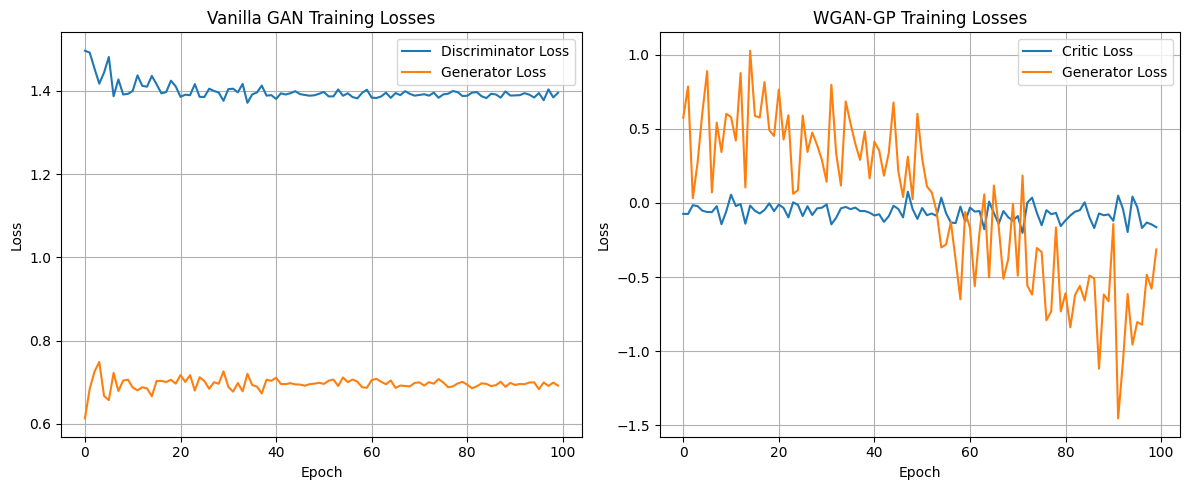

In [ ]:
# --- Plotting Loss Curves ---
print("\n--- Plotting Loss Curves ---")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vanilla_d_losses, label='Discriminator Loss')
plt.plot(vanilla_g_losses, label='Generator Loss')
plt.title('Vanilla GAN Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(wgan_c_losses, label='Critic Loss')
plt.plot(wgan_g_losses, label='Generator Loss')
plt.title('WGAN-GP Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#(Data Preparation)
try:
    df = pd.read_csv('spam.csv', encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv('spam.csv', encoding='latin-1')

spam_df = df[df['v1'] == 'spam']
ham_df = df[df['v1'] == 'ham']
spam_texts = spam_df['v2'].tolist()
ham_texts = ham_df['v2'].tolist()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleaned_spam_texts = [clean_text(text) for text in spam_texts]
cleaned_ham_texts = [clean_text(text) for text in ham_texts]

tokenizer = Tokenizer(num_words=None, oov_token="<unk>")

word_index = tokenizer.word_index
index_word = {v: k for k, v in word_index.items()}
index_word[0] = "<pad>"

lengths = [len(s) for s in tokenizer.texts_to_sequences(cleaned_spam_texts + cleaned_ham_texts)]
max_sequence_length = int(np.percentile(lengths, 90))
if max_sequence_length == 0:
    max_sequence_length = 20

EMBEDDING_DIM = 128
VOCAB_SIZE = len(word_index) + 1
NOISE_DIM = 100


try:
    generator_vanilla = tf.keras.models.load_model('vanilla_gan_generator.h5')
    generator_wgan = tf.keras.models.load_model('wgan_gp_generator.h5')
    print("Trained GAN Generators loaded successfully.")
except Exception as e:
    print(f"Error loading GAN Generators: {e}")
    print("Please ensure you have run Step 2.4 and the .h5 files exist in your directory.")
    # Exit or handle error appropriately if models aren't found
    exit()

# Function to generate text from a generator model
def generate_text_samples(generator_model, num_samples, noise_dim, max_seq_length, index_word_map, vocab_size):
    """
    Generates a specified number of text samples from a trained generator.
    Assumes generator outputs continuous embeddings and projects them to vocabulary logits.
    """
    generated_texts = []
    # Generate in batches to avoid memory issues for very large num_samples
    batch_size_gen = 128 # Can be different from training BATCH_SIZE
    for _ in range(num_samples // batch_size_gen + 1):
        current_batch_size = min(batch_size_gen, num_samples - len(generated_texts))
        if current_batch_size <= 0:
            break

        noise = tf.random.normal([current_batch_size, noise_dim])
        generated_embeddings = generator_model(noise, training=False)

        # Temporary projection layer to convert embeddings back to vocabulary logits
        temp_projection_layer = layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))
        dummy_input = layers.Input(shape=(max_seq_length, generated_embeddings.shape[-1]))
        dummy_output = temp_projection_layer(dummy_input)
        temp_projector_model = models.Model(dummy_input, dummy_output)

        vocab_probabilities = temp_projector_model(generated_embeddings)
        generated_sequences = tf.argmax(vocab_probabilities, axis=-1).numpy()

        for seq in generated_sequences:
            # Convert sequence of IDs back to text, filtering out padding and unknown tokens
            text = ' '.join([index_word_map.get(idx, '') for idx in seq if idx != 0 and index_word_map.get(idx, '') != '<unk>'])
            generated_texts.append(text)
    return generated_texts[:num_samples]

# Calculate how many spam samples are needed to balance the dataset
num_ham_samples = len(ham_df)
num_spam_samples_original = len(spam_df)
samples_to_generate = num_ham_samples - num_spam_samples_original

print(f"\nOriginal Ham samples: {num_ham_samples}")
print(f"Original Spam samples: {num_spam_samples_original}")
print(f"Number of synthetic spam samples to generate: {samples_to_generate}")

# Generate synthetic spam samples
synthetic_spam_vanilla = generate_text_samples(generator_vanilla, samples_to_generate, NOISE_DIM, max_sequence_length, index_word, VOCAB_SIZE)
print(f"Generated {len(synthetic_spam_vanilla)} synthetic spam samples using Vanilla GAN.")

synthetic_spam_wgan = generate_text_samples(generator_wgan, samples_to_generate, NOISE_DIM, max_sequence_length, index_word, VOCAB_SIZE)
print(f"Generated {len(synthetic_spam_wgan)} synthetic spam samples using WGAN-GP.")

# Display a few generated samples for verification
print("\n--- Example Synthetic Spam (Vanilla GAN) ---")
for i, text in enumerate(synthetic_spam_vanilla[:3]):
    print(f"{i+1}: {text}")

print("\n--- Example Synthetic Spam (WGAN-GP) ---")
for i, text in enumerate(synthetic_spam_wgan[:3]):
    print(f"{i+1}: {text}")


Error loading GAN Generators: [Errno 2] Unable to synchronously open file (unable to open file: name = 'vanilla_gan_generator.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Please ensure you have run Step 2.4 and the .h5 files exist in your directory.

Original Ham samples: 4825
Original Spam samples: 747
Number of synthetic spam samples to generate: 4078


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (110, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Generated 4078 synthetic spam samples using Vanilla GAN.
Generated 4078 synthetic spam samples using WGAN-GP.

--- Example Synthetic Spam (Vanilla GAN) ---
1: 
2: 
3: 

--- Example Synthetic Spam (WGAN-GP) ---
1: 
2: 
3: 


In [ ]:
# Dataset 1: Original Imbalanced Dataset
# Already loaded as 'df'

# Dataset 2: Dataset Balanced using Vanilla GAN
synthetic_spam_df_vanilla = pd.DataFrame({'v1': 'spam', 'v2': synthetic_spam_vanilla})
df_vanilla_augmented = pd.concat([df, synthetic_spam_df_vanilla], ignore_index=True)
print(f"Vanilla GAN Augmented Dataset size: {len(df_vanilla_augmented)}")
print(f"Vanilla Augmented Class distribution:\n{df_vanilla_augmented['v1'].value_counts()}")


# Dataset 3: Dataset Balanced using WGAN-GP
synthetic_spam_df_wgan = pd.DataFrame({'v1': 'spam', 'v2': synthetic_spam_wgan})
df_wgan_augmented = pd.concat([df, synthetic_spam_df_wgan], ignore_index=True)
print(f"WGAN-GP Augmented Dataset size: {len(df_wgan_augmented)}")
print(f"WGAN-GP Augmented Class distribution:\n{df_wgan_augmented['v1'].value_counts()}")

#  Classifier Preprocessing

# Encode labels ('ham' -> 0, 'spam' -> 1)
label_encoder = LabelEncoder()
df['v1_encoded'] = label_encoder.fit_transform(df['v1'])
df_vanilla_augmented['v1_encoded'] = label_encoder.transform(df_vanilla_augmented['v1'])
df_wgan_augmented['v1_encoded'] = label_encoder.transform(df_wgan_augmented['v1'])

# Build the MLP Classifier Model
def build_mlp_classifier(vocab_size, embedding_dim, max_sequence_length):
    """
    Builds a simple MLP classifier for text using an Embedding layer.
    """
    model = models.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=max_sequence_length, name='classifier_embedding'),
        layers.LSTM(128),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to Train and Evaluate Classifier
def train_and_evaluate_classifier(name, dataset, tokenizer, max_seq_len, vocab_size, embedding_dim):
    print(f"\n--- Training Classifier on: {name} ---")
    X = dataset['v2'] # Text column
    y = dataset['v1_encoded'] # Encoded labels

    # Convert text to sequences of integers
    X_sequences = tokenizer.texts_to_sequences(X)
    # Pad sequences
    X_padded = pad_sequences(X_sequences, maxlen=max_seq_len, padding='post', truncating='post')

    # Split data into training and testing sets (stratified to maintain class balance)
    X_train, X_test, y_train, y_test = train_test_split(
        X_padded, y, test_size=0.2, random_state=42, stratify=y
    )

    # Build and compile the classifier
    classifier_model = build_mlp_classifier(vocab_size, embedding_dim, max_seq_len)
    classifier_model.summary()

    # Define Early Stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the classifier
    history = classifier_model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate the classifier on the test set
    loss, accuracy = classifier_model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy for {name}: {accuracy:.4f}")

    # Get predictions for detailed metrics
    y_pred_proba = classifier_model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    return y_test, y_pred, classifier_model

# Train and Evaluate for each dataset

# 1. Original Imbalanced Dataset
y_test_original, y_pred_original, model_original = train_and_evaluate_classifier(
    "Original Imbalanced Dataset", df, tokenizer, max_sequence_length, VOCAB_SIZE, EMBEDDING_DIM
)

# 2. Vanilla GAN Augmented Dataset
y_test_vanilla, y_pred_vanilla, model_vanilla = train_and_evaluate_classifier(
    "Vanilla GAN Augmented Dataset", df_vanilla_augmented, tokenizer, max_sequence_length, VOCAB_SIZE, EMBEDDING_DIM
)

# 3. WGAN-GP Augmented Dataset
y_test_wgan, y_pred_wgan, model_wgan = train_and_evaluate_classifier(
    "WGAN-GP Augmented Dataset", df_wgan_augmented, tokenizer, max_sequence_length, VOCAB_SIZE, EMBEDDING_DIM
)



In [ ]:
# --- Define a helper function to calculate and print metrics ---
def evaluate_classifier_performance(name, y_true, y_pred, y_pred_proba=None):
    """
    Calculates and prints common classification metrics.
    Args:
        name (str): Name of the dataset/scenario (e.g., "Original Imbalanced").
        y_true (array-like): True labels.
        y_pred (array-like): Predicted binary labels.
        y_pred_proba (array-like, optional): Predicted probabilities for the positive class.
                                             Required for AUC-ROC. Defaults to None.
    """
    print(f"\n--- Evaluation for: {name} ---")

    # Ensure y_true and y_pred are numpy arrays for consistent indexing
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Spam): {precision:.4f}")
    print(f"Recall (Spam): {recall:.4f}")
    print(f"F1-Score (Spam): {f1:.4f}")


    print("\nConfusion Matrix:")
    print(conf_matrix)

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC-ROC': roc_auc}


# Re-define build_mlp_classifier if this block is run standalone.
def build_mlp_classifier(vocab_size, embedding_dim, max_sequence_length):
    model = models.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=max_sequence_length, name='classifier_embedding'),
        layers.LSTM(128),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Re-define train_and_evaluate_classifier to include y_pred_proba in return
def train_and_evaluate_classifier(name, dataset, tokenizer, max_seq_len, vocab_size, embedding_dim):
    print(f"\n--- Retraining Classifier for Evaluation on: {name} ---")
    X = dataset['v2']
    y = dataset['v1_encoded']

    X_sequences = tokenizer.texts_to_sequences(X)
    X_padded = pad_sequences(X_sequences, maxlen=max_seq_len, padding='post', truncating='post')

    # train_test_split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X_padded, y, test_size=0.2, random_state=42, stratify=y
    )

    classifier_model = build_mlp_classifier(vocab_size, embedding_dim, max_seq_len)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    classifier_model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=0
    )

    loss, accuracy = classifier_model.evaluate(X_test, y_test, verbose=0)
    print(f"  Test Accuracy: {accuracy:.4f}")

    y_pred_proba = classifier_model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    return y_test, y_pred, y_pred_proba


#training and evaluation for each scenario
metrics_results = {}

# 1. Original Imbalanced Dataset
y_test_original, y_pred_original, y_pred_proba_original = train_and_evaluate_classifier(
    "Original Imbalanced Dataset", df, tokenizer, max_sequence_length, VOCAB_SIZE, EMBEDDING_DIM
)
metrics_results['Original'] = evaluate_classifier_performance(
    "Original Imbalanced Dataset", y_test_original, y_pred_original, y_pred_proba_original
)


# 2. Vanilla GAN Augmented Dataset
y_test_vanilla, y_pred_vanilla, y_pred_proba_vanilla = train_and_evaluate_classifier(
    "Vanilla GAN Augmented Dataset", df_vanilla_augmented, tokenizer, max_sequence_length, VOCAB_SIZE, EMBEDDING_DIM
)
metrics_results['Vanilla GAN'] = evaluate_classifier_performance(
    "Vanilla GAN Augmented Dataset", y_test_vanilla, y_pred_vanilla, y_pred_proba_vanilla
)

# 3. WGAN-GP Augmented Dataset
y_test_wgan, y_pred_wgan, y_pred_proba_wgan = train_and_evaluate_classifier(
    "WGAN-GP Augmented Dataset", df_wgan_augmented, tokenizer, max_sequence_length, VOCAB_SIZE, EMBEDDING_DIM
)
metrics_results['WGAN-GP'] = evaluate_classifier_performance(
    "WGAN-GP Augmented Dataset", y_test_wgan, y_pred_wgan, y_pred_proba_wgan
)


# Visualize Metric Comparisons
print("\n--- Comparing Classifier Performance Across Scenarios ---")

metrics_df = pd.DataFrame(metrics_results).T
print("\nOverall Performance Metrics:")
print(metrics_df)

# Plotting
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(4 * len(metrics_to_plot), 5), sharey=True)

for i, metric in enumerate(metrics_to_plot):
    metrics_df[metric].plot(kind='bar', ax=axes[i], color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[i].set_title(metric)
    axes[i].set_ylabel('Score')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
